In [1]:
#makes an example PSTH that shows the tuning on a single channel (Fig 1c)
baseDir = '/oak/stanford/groups/shenoy/fwillett/speechPaperRelease_final/'

In [2]:
import scipy.io
subtractMeansWithinBlock = False

phonemesDat = scipy.io.loadmat(baseDir+'tuningTasks/t12.2022.04.21_phonemes.mat')
orofacialDat = scipy.io.loadmat(baseDir+'tuningTasks/t12.2022.04.21_orofacial.mat')
fiftyWordDat = scipy.io.loadmat(baseDir+'tuningTasks/t12.2022.05.03_fiftyWordSet.mat')

In [3]:
#option to mean-subtract within block
import numpy as np

def meanSubtract(dat):
    dat['binnedTX'] = dat['binnedTX'].astype(np.float32)
    blockList = np.squeeze(np.unique(dat['blockNum']))
    for b in blockList:
        loopIdx = np.squeeze(dat['blockNum']==b)
        dat['binnedTX'][loopIdx,:] -= np.mean(dat['binnedTX'][loopIdx,:],axis=0,keepdims=True)
    return dat

#mean subtraction
if subtractMeansWithinBlock:
    phonemesDat = meanSubtract(phonemesDat)
    orofacialDat = meanSubtract(orofacialDat)
    fiftyWordDat = meanSubtract(fiftyWordDat)

In [4]:
from analysis import triggeredAvg

#get triggered averages for making PSTHs
fAvg_phones, fCI_phones, trials_phones = triggeredAvg(phonemesDat['tx2'].astype(np.float32), 
                         phonemesDat['goTrialEpochs'][:,0],
                         np.squeeze(phonemesDat['trialCues']), [-100,100], smoothSD=4)

2023-06-13 15:40:27.248599: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-13 15:40:27.505491: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-13 15:40:34.594720: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /share/software/user/open/gcc/10.1.0/lib64:/share/software/user/open/gcc/10.1.0/lib/gcc/x86_64-pc-linux-gnu:/share/software/user/open/gcc/10.1.0/lib:/share/software/user/open/cudnn/8.6.0.163/lib:/usr/lib64/nvidia

In [5]:
fAvg_orofacial, fCI_orofacial, trials_orofacial = triggeredAvg(orofacialDat['tx2'].astype(np.float32), 
                         orofacialDat['goTrialEpochs'][:,0],
                         np.squeeze(orofacialDat['trialCues']), [-100,100], smoothSD=4)

In [6]:
fAvg_fiftyWord, fCI_fiftyWord, trials_fiftyWord = triggeredAvg(fiftyWordDat['tx2'].astype(np.float32), 
                         fiftyWordDat['goTrialEpochs'][:,0],
                         np.squeeze(fiftyWordDat['trialCues']), [-100,100], smoothSD=4)

In [18]:
#define the conditions that go into each PSTH panel
eyebrowSet = [5,6,7,8]
eyeSet = [9,10,11,12]
jawSet = [13,14,17,18]
larynxSet = [19,20,21,22]
lipsSet = [23,24,27,28]
tongueSet = [29,30,31,32]
orofacialSets = [eyebrowSet, eyeSet, jawSet, lipsSet, tongueSet, larynxSet]
phonemeSet = [0,5,30,39]
fiftyWordSet = [4,7,20,31]

setTitles = ['Forehead','Eyelids','Jaw','Lips','Tongue','Larynx','Phonemes','Words']

channelIdx = 69 #69
timeAxis = np.arange(-100,100)*0.02

legends = [['Furrow','Raise','Raise Left','Raise Right'],
       ['Close','Open Wide','Wink Left','Wink Right'],
       ['Jaw Clench','Jaw Drop','Jaw Left','Jaw Right'],
       ['Frown','Pucker','Smile','Tuck'],
       ['Tongue Down','Tongue Up','Tongue Left','Tongue Right'],
       ['Hum High','Hum Loud','Hum Low','Hum Soft'],
       ['B','G','IH','AE'],
       ['Bring','Comfortable','Help','Need']]

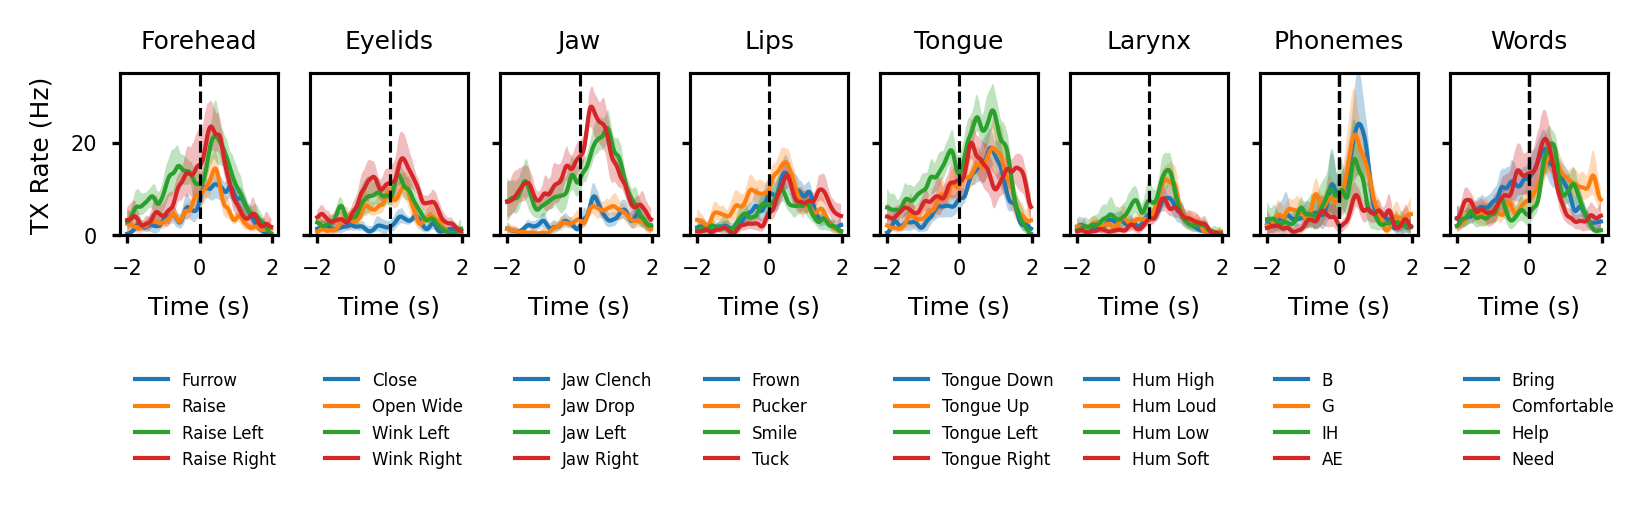

In [21]:
#plot the PSTH for the channel specified by channelIdx
import matplotlib.pyplot as plt
from analysis import plotPreamble

plotPreamble()

if subtractMeansWithinBlock:
    yLimit = [-10,25]
else:
    yLimit = [0,35]
    
plt.figure(figsize=(len(setTitles)*(4/5),0.7), dpi=300)
for setIdx in range(len(orofacialSets)):
    conIdx = orofacialSets[setIdx]
    plt.subplot(1,len(orofacialSets)+2,setIdx+1)
    lines = []
    for c in range(len(conIdx)):
        tmp = plt.plot(timeAxis, 50*fAvg_orofacial[conIdx[c], :, channelIdx],linewidth=1)
        lines.append(tmp[0])
        plt.fill_between(timeAxis, 
                         50*fCI_orofacial[conIdx[c], :, channelIdx,0], 
                         50*fCI_orofacial[conIdx[c], :, channelIdx,1],alpha=0.3)
    plt.ylim(yLimit)
    plt.plot([0,0],plt.gca().get_ylim(),'--k',linewidth=0.75)
    if setIdx>0:
        plt.gca().set_yticklabels([])
    else:
        if subtractMeansWithinBlock:
            plt.ylabel('Δ TX Rate (Hz)')
        else:
            plt.ylabel('TX Rate (Hz)')    
    
    ax = plt.gca()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.75)
    ax.tick_params(length=2)
    
    plt.xlabel('Time (s)')
    plt.title(setTitles[setIdx])
    plt.legend(lines,legends[setIdx],loc='upper left', bbox_to_anchor=(0.0, -0.75),fontsize=4,frameon=False)
    #plt.xlim([-0.5,1.0])
    
plt.subplot(1,len(orofacialSets)+2,len(orofacialSets)+1)
conIdx = phonemeSet
for c in range(len(conIdx)):
    plt.plot(timeAxis, 50*fAvg_phones[conIdx[c], :, channelIdx],linewidth=1)
    plt.fill_between(timeAxis, 
                 50*fCI_phones[conIdx[c], :, channelIdx,0], 
                 50*fCI_phones[conIdx[c], :, channelIdx,1],alpha=0.3)
    plt.ylim(yLimit)
    plt.plot([0,0],plt.gca().get_ylim(),'--k',linewidth=0.75)
    plt.title(setTitles[-2])
    plt.gca().set_yticklabels([])
    plt.xlabel('Time (s)')
    ax = plt.gca()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.75)
    ax.tick_params(length=2)
    plt.legend(lines,legends[-2],loc='upper left', bbox_to_anchor=(0.0, -0.75),fontsize=4,frameon=False)
    
plt.subplot(1,len(orofacialSets)+2,len(orofacialSets)+2)
conIdx = fiftyWordSet
for c in range(len(conIdx)):
    plt.plot(timeAxis, 50*fAvg_fiftyWord[conIdx[c], :, channelIdx],linewidth=1)
    plt.fill_between(timeAxis, 
                 50*fCI_fiftyWord[conIdx[c], :, channelIdx,0], 
                 50*fCI_fiftyWord[conIdx[c], :, channelIdx,1],alpha=0.3)
    plt.ylim(yLimit)
    plt.plot([0,0],plt.gca().get_ylim(),'--k',linewidth=0.75)
    plt.title(setTitles[-1])
    plt.gca().set_yticklabels([])
    plt.xlabel('Time (s)')
    ax = plt.gca()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.75)
    ax.tick_params(length=2)
    plt.legend(lines,legends[-1],loc='upper left', bbox_to_anchor=(0.0, -0.75),fontsize=4,frameon=False)
    
plt.show()